In [2]:
import pandas as pd
import gzip as gz
import numpy as np
from scipy import stats as st
import statsmodels.api
from statsmodels import stats
from bioinfokit import visuz

## Importing and preparing trait data

In [3]:
path = 'C:\\Users\\jenny\\Documents\\NTNU\\Master\\my_supplementary_data\\'
traits_df = pd.read_csv(path + 'database\\subTraitDataset.csv', header = 0, sep = ';', usecols = ['key','gram'])

# removing gram status entries "NaN" and "variable"
traits_df = traits_df.dropna().drop(traits_df[traits_df['gram']=='variable'].index)

# COGs

### Prep

In [4]:
# importing data
COG_df = pd.read_csv(path + 'sequences\\terms_COG.csv', header = 0, sep = ',', names = ['old_index','key','COG'])

# sorting out lower/upper 5% frequency COGs
unique_keys = COG_df['key'].nunique()
lower = unique_keys*0.05
upper = unique_keys*0.95
counts_COG = COG_df.groupby('COG', sort = False)['COG'].transform('size')
mask = (counts_COG > lower) & (counts_COG < upper)
COG_filter_df = COG_df[mask]

# merging prepared COG and trait data
COG_merge = COG_filter_df.merge(traits_df, how = 'inner', on = 'key')

### Fisher exact test
#### Making contingency tables for gram status (pos, neg) and COG (has/lacks)

In [5]:
unique_keys = set(COG_merge['key'])
pos_COG = set(COG_merge.query('gram == "positive"')['key'])
neg_COG = set(COG_merge.query('gram == "negative"')['key'])

# set up result dataframe, with columns COG and keys (all that have the particular COG)
results_COG = COG_merge.groupby('COG', as_index = False).agg({'key': set}).rename({'key':'keys'}, axis=1)

# create contingency tables
def contingency_table(keys):
    rest = unique_keys - keys
    pos_has = len(pos_COG & keys)
    neg_has = len(neg_COG & keys)
    pos_lacks = len(pos_COG & rest)
    neg_lacks = len(neg_COG & rest)    
    return [[pos_has, neg_has], [pos_lacks, neg_lacks]]

results_COG['contingency_ph,nh,pl,nl'] = results_COG['keys'].apply(contingency_table)

# apply Fisher's exact test on created tables
results_COG['fisher'] = results_COG['contingency_ph,nh,pl,nl'].apply(st.fisher_exact)

# organise Fisher's test output: log10, handle inf and -inf odds ratios
  # due to division by 0 following null observations for gram pos/neg with COG
results_COG['odds_ratio'] = results_COG['fisher'].str[0]
results_COG['odds_ratio_log10'] = np.log10(results_COG['odds_ratio'])
results_COG['odds_ratio_log10_corr'] = results_COG['odds_ratio_log10']
thr_COG = 3.0
inf_substitute_COG = thr_COG
inf_neg_substitute_COG = -thr_COG
excl_neg_COG = list()
excl_pos_COG = list()

for r in range(0,len(results_COG)):
    if results_COG.at[r,'odds_ratio_log10'] == np.inf:
        results_COG.at[r,'odds_ratio_log10_corr'] = inf_substitute_COG
        excl_pos_COG.append(results_COG['COG'][r])
    elif results_COG['odds_ratio_log10'][r] == -np.inf:
        results_COG.at[r,'odds_ratio_log10_corr'] = inf_neg_substitute_COG
        excl_neg_COG.append(results_COG['COG'][r])

excl_pos_COG = tuple(excl_pos_COG)
excl_neg_COG = tuple(excl_neg_COG)

results_COG['p-value'] = results_COG['fisher'].str[1]
results_COG = results_COG.drop('fisher', axis = 1)

# correct p-values and organise output
results_COG['reject_null'], results_COG['fdr_p-value'] = statsmodels.stats.multitest.fdrcorrection(results_COG['p-value'])

# make results readily available
pVal_thr_COG = 0.01
FCh_thr_COG = 1.0
results_COG['outcome'] = ''

for r in range(0,len(results_COG)):
    if (-FCh_thr_COG < results_COG['odds_ratio_log10_corr'][r] < FCh_thr_COG or results_COG['fdr_p-value'][r] > pVal_thr_COG):
        results_COG.at[r,'outcome'] = np.nan
    else:
        pos = results_COG['contingency_ph,nh,pl,nl'][r][0][0]
        neg = results_COG['contingency_ph,nh,pl,nl'][r][0][1]
        if pos > neg: results_COG.at[r,'outcome'] = 'positive'
        elif pos < neg: results_COG.at[r,'outcome'] = 'negative'
        else: results_COG.at[r,'outcome'] = 'check'

results_COG.to_csv(path + 'analysis\\fisher_COG.csv', sep = ';')

C:\Users\jenny\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Volcano plot

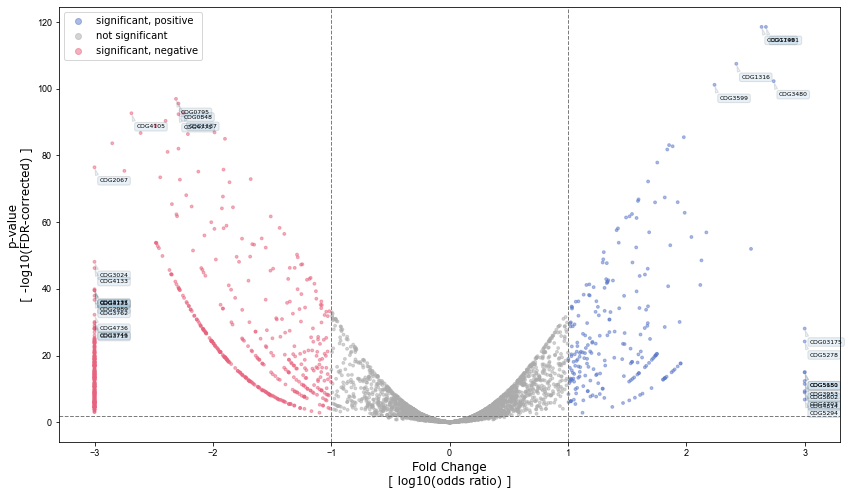

In [6]:
# finding COGs with highest p-values, to assign plot labels
unique_COGs = tuple(list(results_COG['COG']))

best_pVals_COG = list(results_COG.sort_values('fdr_p-value')['fdr_p-value'].head(11))
upper_COGs = tuple(list(results_COG.loc[results_COG['fdr_p-value'] < best_pVals_COG[len(best_pVals_COG)-1], 'COG'].unique()))

# log10 FC and log10 fdr_p-value, significnce levels 0.01 (p) and 1 (FC)

# fetch labels for top significant results from exclusively negative gram-associated COGs
excl_neg_COG_df = pd.DataFrame(excl_neg_COG, columns = ['COG'])
excl_neg_COG_df = excl_neg_COG_df.merge(results_COG, on = 'COG', how = 'inner')
excl_neg_top_COG = tuple(excl_neg_COG_df.sort_values('fdr_p-value').head(11)['COG'].tolist())

visuz.GeneExpression.volcano(df = results_COG,
                             lfc = 'odds_ratio_log10_corr',
                             pv = 'fdr_p-value',
                             lfc_thr = (1,1),
                             pv_thr = (0.01, 0.01),
                             show = True,
                             color = ('#5C79C9', '#ABABAB', '#E8637E'),
                             gstyle = 2,
                             valpha = 0.5,
                             axxlabel = 'Fold Change\n[ log10(odds ratio) ]',
                             axylabel = 'p-value\n[ -log10(FDR-corrected) ]',
                             axlabelfontname = 'Verdana',
                             axlabelfontsize = 12,
                             plotlegend = True,
                             legendlabels = ['significant, positive', 'not significant', 'significant, negative'],
                             legendpos = 'upper left',
                             #legendanchor = [1,1],
                             geneid = 'COG',
                             genenames = upper_COGs + excl_pos_COG + excl_neg_top_COG,
                             sign_line = True,
                             dim = (14,8),
                             ar = 0
                            )

# KOs

In [7]:
# importing data
KO_df = pd.read_csv(path + 'sequences\\terms_KO.csv', header = 0, sep = ',', names = ['old_index', 'key', 'KO'])

# sorting out lower/upper 5% frequency KOs
unique_keys = KO_df['key'].nunique()
lower = unique_keys*0.05
upper = unique_keys*0.95
counts_KO = KO_df.groupby('KO', sort = False)['KO'].transform('size')
mask = (counts_KO > lower) & (counts_KO < upper)
KO_filter_df = KO_df[mask]

# # removing prefix 'ko:'
# KO_filter_df['KO'] = KO_filter_df['KO'].str.split(':').str[1]

# merging prepared KO and trait data
KO_merge = KO_filter_df.merge(traits_df, how = 'inner', on = 'key')

In [8]:
## FISHER
unique_keys = set(KO_merge['key'])
pos_KO = set(KO_merge.query('gram == "positive"')['key'])
neg_KO = set(KO_merge.query('gram == "negative"')['key'])

# set up result dataframe, with columns KO and keys (all that have the particular COG)
results_KO = KO_merge.groupby('KO', as_index = False).agg({'key': set}).rename({'key':'keys'}, axis=1)

# create contingency tables
def contingency_table(keys):
    rest = unique_keys - keys
    pos_has = len(pos_KO & keys)
    neg_has = len(neg_KO & keys)
    pos_lacks = len(pos_KO & rest)
    neg_lacks = len(neg_KO & rest)    
    return [[pos_has, neg_has], [pos_lacks, neg_lacks]]

results_KO['contingency_ph,nh,pl,nl'] = results_KO['keys'].apply(contingency_table)

# apply Fisher's exact test on created tables
results_KO['fisher'] = results_KO['contingency_ph,nh,pl,nl'].apply(st.fisher_exact)

# organise Fisher's test output: log10, hadnle inf and -inf odds ratios
  # due to division by 0 following null observations for gram pos/neg with COG
results_KO['odds_ratio'] = results_KO['fisher'].str[0]
results_KO['odds_ratio_log10'] = np.log10(results_KO['odds_ratio'])
results_KO['odds_ratio_log10_corr'] = results_KO['odds_ratio_log10']
thr_KO = 3.0
inf_substitute_KO = thr_KO
inf_neg_substitute_KO = -thr_KO
excl_neg_KO = list()
excl_pos_KO = list()

for r in range(0,len(results_KO)):
    if results_KO['odds_ratio_log10'][r] == np.inf:
        results_KO.at[r,'odds_ratio_log10_corr'] = inf_substitute_KO
        excl_pos_KO.append(results_KO['KO'][r])
    elif results_KO['odds_ratio_log10'][r] == -np.inf:
        results_KO.at[r,'odds_ratio_log10_corr'] = inf_neg_substitute_KO
        excl_neg_KO.append(results_KO['KO'][r])

excl_pos_KO = tuple(excl_pos_KO)
excl_neg_KO = tuple(excl_neg_KO)

results_KO['p-value'] = results_KO['fisher'].str[1]
results_KO = results_KO.drop('fisher', axis = 1)

# correct p-values and organise output
results_KO['reject_null'], results_KO['fdr_p-value'] = statsmodels.stats.multitest.fdrcorrection(results_KO['p-value'])

# make results readily available
pVal_thr_KO = 0.01
FCh_thr_KO = 1.0
results_KO['outcome'] = ''

for r in range(0,len(results_KO)):
    if (-FCh_thr_KO < results_KO['odds_ratio_log10_corr'][r] < FCh_thr_KO or results_KO['fdr_p-value'][r] > pVal_thr_KO):
        results_KO.at[r,'outcome'] = np.nan
    else:
        pos = results_KO['contingency_ph,nh,pl,nl'][r][0][0]
        neg = results_KO['contingency_ph,nh,pl,nl'][r][0][1]
        if pos > neg: results_KO.at[r,'outcome'] = 'positive'
        elif pos < neg: results_KO.at[r,'outcome'] = 'negative'
        else: results_KO.at[r,'outcome'] = 'check'

results_KO.to_csv(path + 'analysis\\fisher_KO.csv', sep = ';')

C:\Users\jenny\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Volcano plot

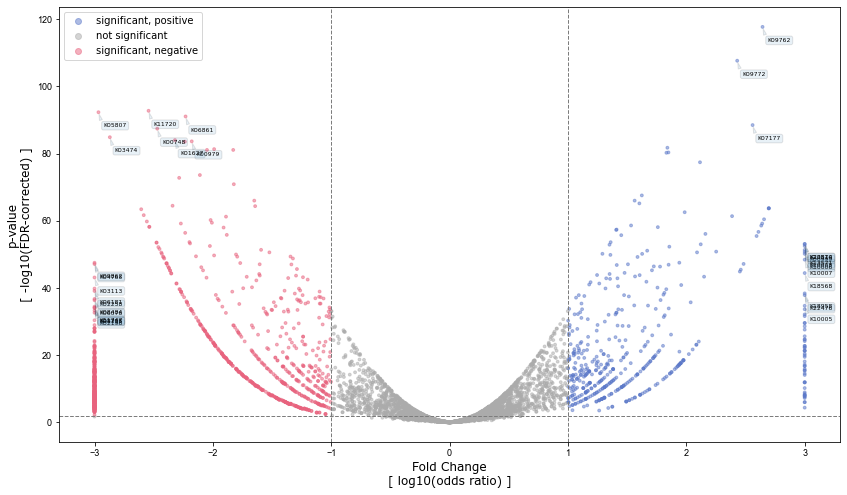

In [9]:
# finding KOs with highest p-values, to assign plot labels
unique_KOs = tuple(list(results_KO['KO']))

best_pVals_KO = list(results_KO.sort_values('fdr_p-value')['fdr_p-value'].head(11))
upper_KOs = tuple(list(results_KO.loc[results_KO['fdr_p-value'] < best_pVals_KO[len(best_pVals_KO)-1], 'KO'].unique()))

# log10 FC and log10 fdr_p-value, significnce levels 0.01 (p) and 1 (FC)

# fetch labels for top significant results from exclusively negative gram-associated KOs
excl_neg_KO_df = pd.DataFrame(excl_neg_KO, columns = ['KO'])
excl_neg_KO_df = excl_neg_KO_df.merge(results_KO, on = 'KO', how = 'inner')
excl_neg_top_KO = tuple(excl_neg_KO_df.sort_values('fdr_p-value').head(11)['KO'].tolist())

# fetch labels for top significant results from exclusively negative positive-associated KOs
excl_pos_KO_df = pd.DataFrame(excl_pos_KO, columns = ['KO'])
excl_pos_KO_df = excl_pos_KO_df.merge(results_KO, on = 'KO', how = 'inner')
excl_pos_top_KO = tuple(excl_pos_KO_df.sort_values('fdr_p-value').head(11)['KO'].tolist())

visuz.GeneExpression.volcano(df = results_KO,
                             lfc = 'odds_ratio_log10_corr',
                             pv = 'fdr_p-value',
                             lfc_thr = (1,1),
                             pv_thr = (0.01, 0.01),
                             show = True,
                             color = ('#5C79C9', '#ABABAB', '#E8637E'),
                             gstyle = 2,
                             valpha = 0.5,
                             axxlabel = 'Fold Change\n[ log10(odds ratio) ]',
                             axylabel = 'p-value\n[ -log10(FDR-corrected) ]',
                             axlabelfontname = 'Verdana',
                             axlabelfontsize = 12,
                             plotlegend = True,
                             legendlabels = ['significant, positive', 'not significant', 'significant, negative'],
                             legendpos = 'upper left',
                             #legendanchor = [1,1],
                             geneid = 'KO',
                             genenames = upper_KOs + excl_pos_top_KO + excl_neg_top_KO,
                             sign_line = True,
                             dim = (14,8),
                             ar = 0
                            )

# GOs

In [10]:
# importing data
GO_df = pd.read_csv(path + 'sequences\\terms_GO.csv', header = 0, sep = ',', names = ['old_index', 'key', 'GO'])

# sorting out lower/upper 5% frequency GOs
unique_keys = GO_df['key'].nunique()
lower = unique_keys*0.05
upper = unique_keys*0.95
counts_GO = GO_df.groupby('GO', sort = False)['GO'].transform('size')
mask = (counts_GO > lower) & (counts_GO < upper)
GO_filter_df = GO_df[mask]

# merging prepared GO and trait data
GO_merge = GO_filter_df.merge(traits_df, how = 'inner', on = 'key')

In [11]:
## FISHER
unique_keys = set(GO_merge['key'])
pos_GO = set(GO_merge.query('gram == "positive"')['key'])
neg_GO = set(GO_merge.query('gram == "negative"')['key'])

# set up result dataframe, with columns GO and keys (all that have the particular COG)
results_GO = GO_merge.groupby('GO', as_index = False).agg({'key': set}).rename({'key':'keys'}, axis=1)

# create contingency tables
def contingency_table(keys):
    rest = unique_keys - keys
    pos_has = len(pos_GO & keys)
    neg_has = len(neg_GO & keys)
    pos_lacks = len(pos_GO & rest)
    neg_lacks = len(neg_GO & rest)    
    return [[pos_has, neg_has], [pos_lacks, neg_lacks]]

results_GO['contingency_ph,nh,pl,nl'] = results_GO['keys'].apply(contingency_table)

# apply Fisher's exact test on created tables
results_GO['fisher'] = results_GO['contingency_ph,nh,pl,nl'].apply(st.fisher_exact)

# organise Fisher's test output: log10, hadnle inf and -inf odds ratios
  # due to division by 0 following null observations for gram pos/neg with COG
results_GO['odds_ratio'] = results_GO['fisher'].str[0]
results_GO['odds_ratio_log10'] = np.log10(results_GO['odds_ratio'])
results_GO['odds_ratio_log10_corr'] = results_GO['odds_ratio_log10']
thr_GO = 3.0
inf_substitute_GO = thr_GO
inf_neg_substitute_GO = -thr_GO
excl_neg_GO = list()
excl_pos_GO = list()

for r in range(0,len(results_GO)):
    if results_GO['odds_ratio_log10'][r] == np.inf:
        results_GO.at[r,'odds_ratio_log10_corr'] = inf_substitute_GO
        excl_pos_GO.append(results_GO['GO'][r])
    elif results_GO['odds_ratio_log10'][r] == -np.inf:
        results_GO.at[r,'odds_ratio_log10_corr'] = inf_neg_substitute_GO
        excl_neg_GO.append(results_GO['GO'][r])

excl_pos_GO = tuple(excl_pos_GO)
excl_neg_GO = tuple(excl_neg_GO)

results_GO['p-value'] = results_GO['fisher'].str[1]
results_GO = results_GO.drop('fisher', axis = 1)

# correct p-values and organise output
results_GO['reject_null'], results_GO['fdr_p-value'] = statsmodels.stats.multitest.fdrcorrection(results_GO['p-value'])

# make results readily available
pVal_thr_GO = 0.01
FCh_thr_GO = 1.0
results_GO['outcome'] = ''

for r in range(0,len(results_GO)):
    if (-FCh_thr_GO < results_GO['odds_ratio_log10_corr'][r] < FCh_thr_GO or results_GO['fdr_p-value'][r] > pVal_thr_GO):
        results_GO.at[r,'outcome'] = np.nan
    else:
        pos = results_GO['contingency_ph,nh,pl,nl'][r][0][0]
        neg = results_GO['contingency_ph,nh,pl,nl'][r][0][1]
        if pos > neg: results_GO.at[r,'outcome'] = 'positive'
        elif pos < neg: results_GO.at[r,'outcome'] = 'negative'
        else: results_GO.at['outcome'] = 'check'

results_GO.to_csv(path + 'analysis\\fisher_GO.csv', sep = ';')

C:\Users\jenny\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Volcano plot

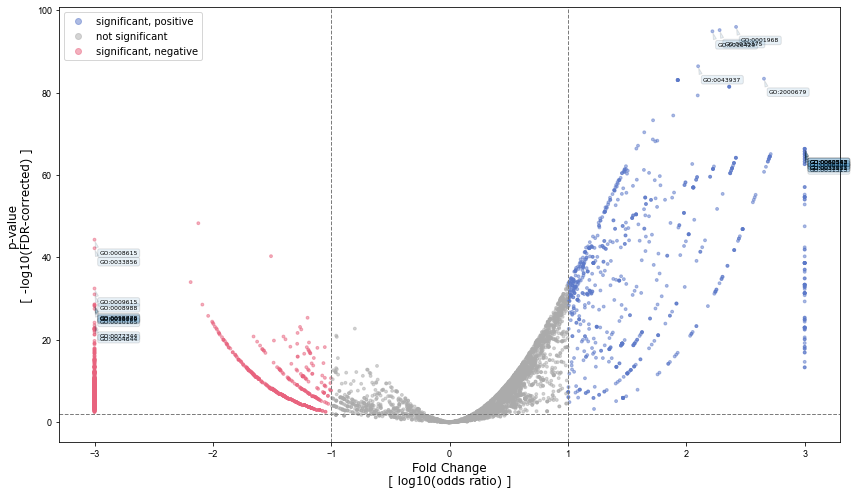

In [12]:
# finding GOs with highest p-values, to assign plot labels
unique_GOs = tuple(list(results_GO['GO']))

best_pVals_GO = list(results_GO.sort_values('fdr_p-value')['fdr_p-value'].head(11))
upper_GOs = tuple(list(results_GO.loc[results_GO['fdr_p-value'] < best_pVals_GO[len(best_pVals_GO)-1], 'GO'].unique()))

# log10 FC and log10 fdr_p-value, significnce levels 0.01 (p) and 1 (FC)

# fetch labels for top significant results from exclusively negative gram-associated KOs
excl_neg_GO_df = pd.DataFrame(excl_neg_GO, columns = ['GO'])
excl_neg_GO_df = excl_neg_GO_df.merge(results_GO, on = 'GO', how = 'inner')
excl_neg_top_GO = tuple(excl_neg_GO_df.sort_values('fdr_p-value').head(11)['GO'].tolist())

# fetch labels for top significant results from exclusively negative positive-associated KOs
excl_pos_GO_df = pd.DataFrame(excl_pos_GO, columns = ['GO'])
excl_pos_GO_df = excl_pos_GO_df.merge(results_GO, on = 'GO', how = 'inner')
excl_pos_top_GO = tuple(excl_pos_GO_df.sort_values('fdr_p-value').head(11)['GO'].tolist())

visuz.GeneExpression.volcano(df = results_GO,
                             lfc = 'odds_ratio_log10_corr',
                             pv = 'fdr_p-value',
                             lfc_thr = (1,1),
                             pv_thr = (0.01, 0.01),
                             show = True,
                             color = ('#5C79C9', '#ABABAB', '#E8637E'),
                             gstyle = 2,
                             valpha = 0.5,
                             axxlabel = 'Fold Change\n[ log10(odds ratio) ]',
                             axylabel = 'p-value\n[ -log10(FDR-corrected) ]',
                             axlabelfontname = 'Verdana',
                             axlabelfontsize = 12,
                             plotlegend = True,
                             legendlabels = ['significant, positive', 'not significant', 'significant, negative'],
                             legendpos = 'upper left',
                             #legendanchor = [1,1],
                             geneid = 'GO',
                             genenames = upper_GOs + excl_pos_top_GO + excl_neg_top_GO,
                             sign_line = True,
                             dim = (14,8),
                             ar = 0
                            )